# MixedML on Python

In [ ]:
# DO NOT EXECUTE: THE R FILE HAVE CHANGED TO USE ALL FEATURES!!!

STOOOOOP

In [1]:
from sys import path

path.append("../")

import seaborn as sns
from matplotlib.pyplot import subplots
from pandas import DataFrame
import pandas as pd
from reservoirpy import verbosity
from reservoirpy.nodes import Reservoir, Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler


from training_utils.data import get_dataframe, remove_warmup_1D
from training_utils.global_config import N_WARMUPS
from mixed_ml import MixedMLEstimator

pd.options.display.float_format = "{:.3e}".format
verbosity(0)

0

In [2]:
data = get_dataframe("../../../data/synthetic_bph_1/01_test.csv")
SERIES = "individus"
TSTEPS = "temps"
#
data_train = data[data[SERIES] > 10]
data_test = data[data[SERIES] <= 10]

## Building the model 

Standard models can be used:

In [3]:
model_mlp = MLPRegressor((20, 10, 5), learning_rate="adaptive", max_iter=1000)
mixed_ml_mlp = MixedMLEstimator(model_mlp, recurrent_model=False)

Also recurrent ones:

In [14]:
model_rpy = Reservoir(units=50) >> Ridge(ridge=1e-1)
mixed_ml_rpy = MixedMLEstimator(model_rpy, recurrent_model=True)

## Training  
with simple features: x2_x5, x4_x7, x6_x8

In [6]:
X_LABELS = ["x2_x5", "x4_x7", "x6_x8"]
Y_LABEL = "y_mixed_obs"

scaler_x = RobustScaler()
scaler_y = RobustScaler()

data_train_scaled = data_train[[SERIES, TSTEPS]].copy()
data_train_scaled[X_LABELS] = scaler_x.fit_transform(data_train[X_LABELS])
data_train_scaled[[Y_LABEL]] = scaler_y.fit_transform(data_train[[Y_LABEL]])

data_test_scaled = data_test[[SERIES, TSTEPS]].copy()
data_test_scaled[X_LABELS] = scaler_x.transform(data_test[X_LABELS])
data_test_scaled[[Y_LABEL]] = scaler_y.transform(data_test[[Y_LABEL]])

In [7]:
results_mlp = mixed_ml_mlp.fit(
    data_train_scaled, n_iter_improve=2, min_ratio_improve=0.01
)

mixedML step #00: 9.851597e-03 (best)
mixedML step #01: 6.173452e-03 (best)
mixedML step #02: 4.630533e-03 (best)
mixedML step #03: 4.319146e-03 (best)
mixedML step #04: 4.175077e-03 (best)
mixedML step #05: 3.660782e-03 (best)
mixedML step #06: 3.787219e-03
mixedML step #07: 3.395922e-03 (best)
mixedML step #08: 3.467191e-03
mixedML step #09: 3.317139e-03 (best)
mixedML step #10: 3.179771e-03 (best)
mixedML step #11: 3.141904e-03 (best)
mixedML step #12: 3.140226e-03
mixedML step #13: 3.074510e-03 (best)
mixedML step #14: 3.109384e-03
mixedML step #15: 3.062500e-03
mixedML step #16: 3.094006e-03


In [16]:
results_rpy = mixed_ml_rpy.fit(
    data_train_scaled,
    n_iter_improve=2,
    min_ratio_improve=0.01,
    fixed_model_options={"warmup": N_WARMUPS},
)

mixedML step #00: 6.636570e-02 (best)
mixedML step #01: 3.069191e-02 (best)
mixedML step #02: 1.951671e-02 (best)
mixedML step #03: 1.440845e-02 (best)
mixedML step #04: 1.148200e-02 (best)
mixedML step #05: 9.577532e-03 (best)
mixedML step #06: 8.251368e-03 (best)
mixedML step #07: 7.290986e-03 (best)
mixedML step #08: 6.576557e-03 (best)
mixedML step #09: 6.033452e-03 (best)
mixedML step #10: 5.612438e-03 (best)
mixedML step #11: 5.279909e-03 (best)
mixedML step #12: 5.012427e-03 (best)
mixedML step #13: 4.793401e-03 (best)
mixedML step #14: 4.610958e-03 (best)
mixedML step #15: 4.456519e-03 (best)
mixedML step #16: 4.323832e-03 (best)
mixedML step #17: 4.208298e-03 (best)
mixedML step #18: 4.106504e-03 (best)
mixedML step #19: 4.015891e-03 (best)
mixedML step #20: 3.934520e-03 (best)
mixedML step #21: 3.860903e-03 (best)
mixedML step #22: 3.793885e-03 (best)
mixedML step #23: 3.732557e-03 (best)
mixedML step #24: 3.676195e-03 (best)
mixedML step #25: 3.624212e-03 (best)
mixedML step

In [17]:
def plot_convergence(results_mlp, results_rpy):
    fig, ax = subplots()
    ax.plot(results_mlp, label="MLP")
    ax.plot(results_rpy, label="Reservoir")
    ax.legend(loc="center right", fontsize="x-large")
    ax.set_yscale("log")
    ax.set_title("Convergence")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Model residuals (on scaled values)")
    _ = 0

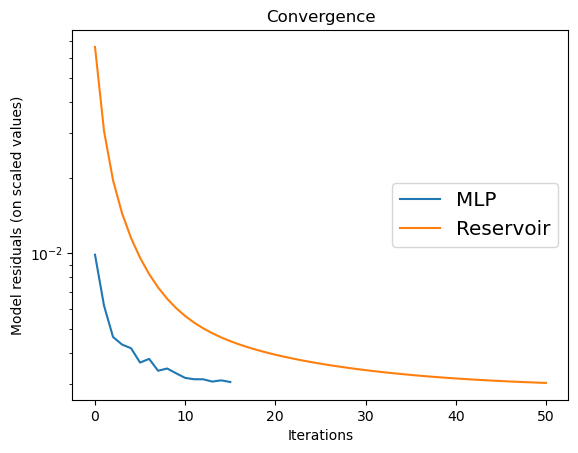

In [18]:
plot_convergence(results_mlp, results_rpy)

# Predictions

In [19]:
def get_predictions(mixed_ml_mlp, mixed_ml_rpy):
    lres = []
    for name, model in {"MLP": mixed_ml_mlp, "Reservoir": mixed_ml_rpy}.items():
        for subspec in [True, False]:
            y_pred_scaled = model.predict(
                data_test_scaled, use_subject_specific=subspec
            )
            y_pred_scaled = y_pred_scaled.reshape((len(y_pred_scaled), 1))
            y_pred = scaler_y.inverse_transform(y_pred_scaled)
            lres.append(
                {
                    "model": name,
                    "ss": subspec,
                    "mse": mse(
                        remove_warmup_1D(data_test[Y_LABEL], N_WARMUPS),
                        remove_warmup_1D(y_pred, N_WARMUPS),
                    ),
                }
            )
    return DataFrame(lres)

In [20]:
get_predictions(mixed_ml_mlp, mixed_ml_rpy)

,model,ss,mse
0,MLP,True,1.034e+00
1,MLP,False,6.714e+01
2,Reservoir,True,1.004e+00
3,Reservoir,False,1.848e+02
